# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

# All of your work for this exercise will be done in this notebook

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
# This cell is kind of slow (        ~ O(1 minute/60 secs)     ("on the order of 30 seconds")   )
from cs231n.features import *

import time
tic = time.time()

num_color_bins = 10 # Number of bins in the color histogram
feature_fns    = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats  = extract_features(X_train, feature_fns, verbose=True)
X_val_feats    = extract_features(X_val, feature_fns)
X_test_feats   = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat      = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats   -= mean_feat
X_test_feats  -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat       = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats   /= std_feat
X_test_feats  /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats  = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats    = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats   = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

toc = time.time()
print("This cell took %f seconds to run." %(toc-tic))

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [4]:
#print("X_train_feats.shape: ",X_train_feats.shape)
#print("X_val_feats.shape  : ",X_val_feats.shape)
#print("X_test_feats.shape : ",X_test_feats.shape)

'''
X_train_feats.shape:  (49000, 155)
X_val_feats.shape  :  (1000, 155)
X_test_feats.shape :  (1000, 155)
'''
None

In [5]:
# Debugging:


"""
plt.imshow(X_train[0] /255)
plt.show()
hist=  color_histogram_hsv(X_train[0])
print("color histogram HSV: ", hist)

normalized=True
xmin=0
xmax=255
nbin=10
im=X_train[0]
ndim=X_train[0].ndim
bins=np.linspace(xmin, xmax, nbin+1)
hsv = matplotlib.colors.rgb_to_hsv(im/xmax) * xmax
HUE=0 # TODO:  double-triple-double-check that this IS "hue" and not "value"
plt.imshow(hsv[:,:,HUE])

imhist, bin_edges = np.histogram(hsv[:,:,HUE], bins=bins, density=normalized)
print("before the line of code  'imhist = imhist * np.diff(bin_edges)'\
\nimhist={0}\n and\nbin_edges={1}: ".format(imhist, bin_edges))
imhist = imhist * np.diff(bin_edges)
print("imhist: ", imhist)

"""


'''
color histogram HSV:  [0.828125   0.16601562 0.00195312 0.         0.00097656 0.00195312
 0.         0.         0.         0.00097656]
before the line of code  'imhist = imhist * np.diff(bin_edges)'
imhist=[3.24754902e-02 6.51041667e-03 7.65931373e-05 0.00000000e+00
 3.82965686e-05 7.65931373e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.82965686e-05]
 and
bin_edges=[  0.   25.5  51.   76.5 102.  127.5 153.  178.5 204.  229.5 255. ]: 
imhist:  [0.828125   0.16601562 0.00195312 0.         0.00097656 0.00195312
 0.         0.         0.         0.00097656]

Basically, by the end of "color_histogram_hsv", 
the return value 'imhist' tells you how many of the pixels are at each value 

'''
None

In [6]:
# for debugging:

"""
from copy import deepcopy
BLACK=0
WHITE=255
HUE=0
bw_img = deepcopy(im)
#bw_img = np.full(  im[:,:,0].shape, 0.5) #BLACK) #WHITE)
plt.clf()
plt.imshow(bw_img[:,:,0])
plt.show()

print(hsv.dtype) # "float64"
plt.imshow(hsv /255) #3[:,:,HUE])
plt.show()
plt.imshow(im/255)
plt.show()
print("the following value SHOULD be a positive integer near 0 (not 255) if the scale is 0-255,\n or a float near 0 (not near 1) if the scale is 0-1")
print("np.mean(hsv[:,:,HUE]): ", np.mean(hsv[:,:,HUE]))
"""


None

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [7]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM
"""
min_lr8 = 1e-30 #1e-8
max_lr8 = 1e+30 # too big
n_lr8s=7 #100

# I think lr=1 was the most successful

l_r8s=np.logspace(
    math.log10(min_lr8),
    math.log10(max_lr8),
    n_lr8s
)
learning_rates = l_r8s
"""
learning_rates = [1]



regularization_strengths = [0]  #[5e-4]  #[5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

epochs=2000

# TODO:  use HOG / color histogram variables:
#   (X_train_feats, X_val_feats, and X_test_feats)
for lr in learning_rates:
    for reg in regularization_strengths:
        svm=LinearSVM()

        loss_hist = svm.train(
            X_train_feats,
            y_train,
            learning_rate=lr,
            reg=reg,
            num_iters=epochs,
            verbose=False)# =True) # False)
        # Predict:
        #   and then store accuracies in "train" and "val"
        train    = np.mean( svm.predict(X_train_feats) == y_train)
        val      = np.mean( svm.predict(X_val_feats)   == y_val)

        # Save best:
        if val > best_val:
            best_val = val
            best_svm = svm

        # Save all:
        results[(lr, reg)] = (train, val)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e+00 reg 0.000000e+00 train accuracy: 0.417510 val accuracy: 0.421000
best validation accuracy achieved during cross-validation: 0.421000


In [8]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.39


In [9]:
# save the SVM with   the best test_acc
import pickle as pkl
test_acc=test_accuracy
pkl_fname = "best_SVM_from_features.ipynb__test_acc_is_{0}.pkl".format(test_acc)
with open(pkl_fname, "wb") as out_pkl_file:
    pkl.dump(best_svm, out_pkl_file)

In [10]:
"""
# load old SVM that was working 
#   and new SVM that broke for some ****ing reason
import pickle as pkl
pkl_fname = "best_SVM_from_features.ipynb__test_acc_is_0.425.pkl"
with open(pkl_fname, "rb") as in_pkl_fp:
    working_SVM=pkl.load(in_pkl_fp)

    
import pickle as pkl
pkl_fname = "best_SVM_from_features.ipynb__test_acc_is_0.124.pkl"
with open(pkl_fname, "rb") as in_pkl_fp:
    shit_SVM=pkl.load(in_pkl_fp)
"""
    

'\n# load old SVM that was working \n#   and new SVM that broke for some ****ing reason\nimport pickle as pkl\npkl_fname = "best_SVM_from_features.ipynb__test_acc_is_0.425.pkl"\nwith open(pkl_fname, "rb") as in_pkl_fp:\n    working_SVM=pkl.load(in_pkl_fp)\n\n    \nimport pickle as pkl\npkl_fname = "best_SVM_from_features.ipynb__test_acc_is_0.124.pkl"\nwith open(pkl_fname, "rb") as in_pkl_fp:\n    shit_SVM=pkl.load(in_pkl_fp)\n'

In [25]:
"""
#dir(working_SVM)
print("working_SVM.W  (weights) : \n\n", working_SVM.W)
"""
None

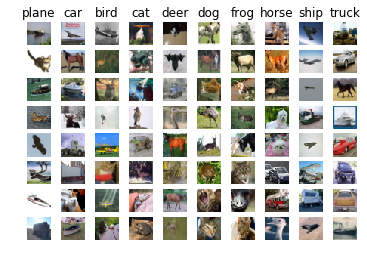

In [12]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$

As long as the colors and HOG histograms match the training data, the SVM will misclassify.  For instance, for the "plane" class, perhaps a lot of the background colors are sky (HSV "hue" of blue/blue-gray sky)

As for the HOG gradients, any edges or noteworthy textures, internal patterns much be close enough to the calculated HOG features in the training images.  For instance, ths picture below.  ![Example of HOG](https://scikit-image.org/docs/dev/_images/sphx_glr_plot_hog_001.png)


So if the misclassified deer in the upper-left-hand corner of our images is positioned similarly to how a plane should be positioned (ie. its edges are positioned the same, etc.), its HOG features will look the same as a plane's would, and our SVM will misclassify it as "plane".  For instance, this image has a strong ground-sky border which the HOG might have picked up in many of the real "plane" images; wherever there's a line separating sky from green ground, the classifier will interpret that as meaning there's a plane in the image.  This is not what we want.

The same is true of the color; a predominantly blue scene could mean either ocean or sky or a blue painted wall, and a 4-year-old could tell between these three things.  Our vision system has to perform similarly well.

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [26]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 153)
(49000, 152)


In [69]:
from cs231n.classifiers.neural_net import TwoLayerNet

from collections import OrderedDict
import math
import time

input_dim   = X_train_feats.shape[1]
hidden_dim  = 500
num_classes =  10

net         = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net    = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

best_val    = -1



#=====================================================
#   learning rates:
#=====================================================

"""
#=====================================================
#     lr=1 was good.  I could also pull out the old highly-performant NN (best_2_layer_NN__on_features_____test_acc_is_0.574.pkl) and tune it ever so slightly
#=====================================================
max_lr8 = 3e+0 #1e+2       # NOTE: I JUST changed max_lr8 and min_lr8 after transitioning batch_size=100 => bs=1000
min_lr8 = 3e-2 #1e-8
n_lr8s  = 25 #17  #11 #100

l_r8s=np.logspace(
    math.log10(min_lr8),
    math.log10(max_lr8),
    n_lr8s
)
# noise
l_r8s+= (np.random.random(
    l_r8s.shape,
) * 3e-2)   # unfortunately the noise on the lower end is much more significant than on the upper end
#================= NOTE: single lr ===================
#l_r8s=[1e-3]   # 1e-3 too low?       lr=1   seemed p successful on both the val and test sets (no reg).
"""
l_r8s=[1. +\
      np.random.random()*1e-2] # noise    on top of real lr

#=====================================================
#   regularization strengths
#=====================================================
"""
min_reg=1e-9
max_reg=1e+9
n_regs=4
regs=np.logspace(
    math.log10(min_reg),
    math.log10(max_reg),
    num=n_regs
)
"""
#================= NOTE: single reg ==================
regs=[0] # off initially
regs = [-1e-8, -1e-7, -1e-9, 0, 1e-9, 1e-8, 1e-7, 1e-2]

#=====================================================
# epochs  ("num_iterations")
#=====================================================
"""
min_ni = 300
max_ni = 3000
n_ni   = 15
nis= np.round(
    np.logspace(
        math.log10(min_ni),
        math.log10(max_ni),
        num=n_ni,
        base=10.
    )
).astype('int64')
#nis+= np.random.random()
"""
#================= NOTE: single ni ===================

nis=[1000]  #[500]#[3000] #[500]

# try more epochs?   (do this after we've maximized batch_size)

#=====================================================
# batch sizes    ("bs")
#=====================================================
bs=1000 #300   #100    #250 # Was it 100 before?   Yes.  Wow, even the bs is important.

#=====================================================
# learning rate decay:
#=====================================================
lrd=0.95

tic = time.time()
results=OrderedDict()
repeats=3  # duplicate runs w/ same parameters    # 15 b/c sometimes the initializations are just shitty.  Randomness is on your side if you do lots of trials and happen to find a good setting of the SVM
ctr=0
for i in range(repeats):
    for l_r8 in l_r8s:
        for reg in regs:
            for ni in nis:
                net = TwoLayerNet(input_dim, hidden_dim, num_classes)

                stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                            num_iters=ni,
                            batch_size=bs,
                            learning_rate=l_r8,
                            learning_rate_decay=lrd,
                            reg=reg,
                            verbose=False) #True) #False)

                #loss_hist     = stats['loss_history']
                train_acc_hist= stats['train_acc_history']
                val_acc_hist  = stats['val_acc_history']
                val           = val_acc_hist[-1]
                train         = train_acc_hist[-1]

                #print("The NN currently being trained's parameters: {0}".format(net.hyperparams))
                #print("accuracies: \n val = {0} \n train ={1}\n".format(val, train))
                
                
                # Save best:
                if val > best_val:
                    best_net = net
                    best_val = val
                    bests_stats=stats
                    print("best_val is %f" %best_val)
                    print("reg is %f" %reg)
                    #print("num_iters is %i" %ni)
                    #print("lr is %f" %l_r8)
                    print("iter %d" %ctr)
                #results[(lr, reg)] = (train, val)
                results[(l_r8, reg, hidden_dim, ni)] = (train, val)
                ctr+=1


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg, hidden_dim, ni in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, hidden_dim, ni)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f  \n\n' % best_val)
print("%i training sessions" % ctr)

toc = time.time()
print('training run computed in %fs' % (toc - tic))  
# training run computed in   41.918771s #bs== 100, n_iters==500
# training run computed in  338.126556s #bs==1000, n_iters==500       (10x as much time!   Aaaaaargh.  And for only a tiny bit of performance gain (52% => 58% on val))

#=====================================================
# n_iters:
# 5 training sessions:
# training run computed in 1227.353535s #bs==1000, n_iters==300-30000 in logspace()

#=====================================================
# Regularization:
# 4 training sess   
# training run computed in ~500.00s (I'm estimating) # bs==1000, n_iters==1500
#


best_val is 0.607000
reg is -0.000000
iter 0
best_val is 0.610000
reg is 0.000000
iter 3
best_val is 0.611000
reg is 0.000000
iter 13
best_val is 0.613000
reg is 0.000000
iter 21
lr 1.007458e+00 reg -1.000000e-07 train accuracy: 0.829000 val accuracy: 0.598000
lr 1.007458e+00 reg -1.000000e-08 train accuracy: 0.820000 val accuracy: 0.600000
lr 1.007458e+00 reg -1.000000e-09 train accuracy: 0.816000 val accuracy: 0.603000
lr 1.007458e+00 reg 0.000000e+00 train accuracy: 0.836000 val accuracy: 0.598000
lr 1.007458e+00 reg 1.000000e-09 train accuracy: 0.816000 val accuracy: 0.597000
lr 1.007458e+00 reg 1.000000e-08 train accuracy: 0.810000 val accuracy: 0.613000
lr 1.007458e+00 reg 1.000000e-07 train accuracy: 0.822000 val accuracy: 0.606000
lr 1.007458e+00 reg 1.000000e-02 train accuracy: 0.611000 val accuracy: 0.573000
best validation accuracy achieved during cross-validation: 0.613000  


24 training sessions
training run computed in 1029.104955s


In [70]:
regs

[-1e-08, -1e-07, -1e-09, 0, 1e-09, 1e-08, 1e-07, 0.01]

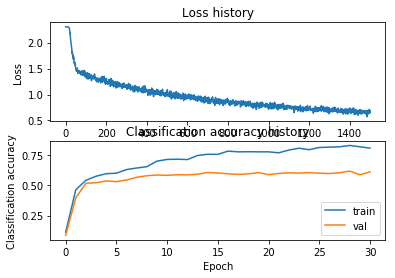

In [71]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(bests_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(bests_stats['train_acc_history'], label='train')
plt.plot(bests_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
# Each epoch is 1,000 iters.
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

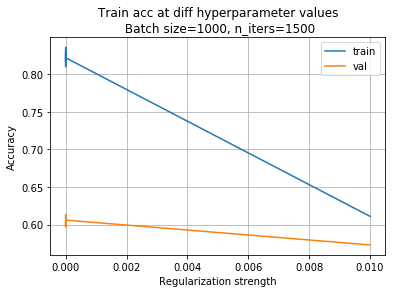

In [79]:
# Plot the loss at various hyperparam values:
# 1. lr
# 2. # train epochs  ("ni")

#results[(l_r8, reg)] = (train, val)
params_x = []
train_y  = []
val_y    = []

LR=0
REG=1
HIDDEN=2
ITERS=3
#=========================================================
#=========================================================
#=========================================================
WHICH=REG #ITERS  #<== TODO FIXME    change this "WHICH" variable to plot different variables on the x axis.
#=========================================================
#=========================================================
#=========================================================
for k, v in results.items():
    params_x.append(k[WHICH])
    train_y.append(v[0])
    val_y.append(v[1])

# lr :


plt.title('Train acc at diff hyperparameter values\n Batch size=%i, n_iters=%i' % (bs, ni) )
#plt.xlabel('Number of Training Iterations')
#plt.xlabel('Learning Rate')
#plt.xlabel('Hidden Layer\'s size')
plt.xlabel('Regularization strength')
plt.ylabel('Accuracy')
plt.plot(params_x, train_y, label='train')
plt.plot(params_x, val_y,   label='val')
plt.xscale('log')
plt.grid(True)

#plt.subplot(2, 1, 2)
#plt.plot(stats['train_acc_history'], label='train')
#plt.plot(stats['val_acc_history'], label='val')
#plt.title('Classification accuracy history')
#plt.xlabel('Epoch')
#plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

In [73]:
results

OrderedDict([((1.007457645076569, -1e-08, 500, 1500), (0.82, 0.6)),
             ((1.007457645076569, -1e-07, 500, 1500), (0.829, 0.598)),
             ((1.007457645076569, -1e-09, 500, 1500), (0.816, 0.603)),
             ((1.007457645076569, 0, 500, 1500), (0.836, 0.598)),
             ((1.007457645076569, 1e-09, 500, 1500), (0.816, 0.597)),
             ((1.007457645076569, 1e-08, 500, 1500), (0.81, 0.613)),
             ((1.007457645076569, 1e-07, 500, 1500), (0.822, 0.606)),
             ((1.007457645076569, 0.01, 500, 1500), (0.611, 0.573))])

In [74]:
# Run your best neural net classifier on the validation set. You should be able
# to get more than 55% accuracy.

val_acc = (best_net.predict(X_val_feats) == y_val).mean()
print(val_acc)

0.607


In [75]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.591


In [76]:
import pickle as pkl
pkl_fname = "best_2_layer_NN__on_features_____test_acc_is_{0}.pkl".format(test_acc)
with open(pkl_fname, "wb") as out_pkl_file:
        pkl.dump(best_net, out_pkl_file)

In [80]:
best_net.hyperparams

OrderedDict([('learning_rate', 1.007457645076569),
             ('reg', 1e-08),
             ('H', 500),
             ('num_iters', 1500),
             ('batch_size', 1000)])

In [78]:
best_net.params

{'W1': array([[ 1.85599556e-02, -1.37329890e-02,  6.57323415e-02, ...,
          3.59634087e-02, -1.30212098e-01,  2.84739670e-02],
        [ 2.80949967e-02,  4.95915153e-02,  5.28732259e-02, ...,
          2.89181403e-02, -5.90289062e-02, -2.29722955e-03],
        [ 3.26470493e-02,  2.02050683e-02,  4.62996995e-02, ...,
          5.96821968e-02, -1.19569214e-02, -2.33170295e-03],
        ...,
        [ 2.14691149e-04, -7.21764366e-02,  3.68497062e-01, ...,
         -2.32658062e-02,  2.30549673e-02, -2.81152360e-02],
        [ 1.12381107e-02, -4.47669073e-02,  1.98284408e-01, ...,
          2.94081067e-02,  7.85176544e-02, -2.14099414e-02],
        [ 5.32951382e-02, -4.60401694e-02,  7.51540916e-02, ...,
          4.78302669e-02,  1.86037430e-02,  2.20713080e-02]]),
 'W2': array([[-0.0874435 ,  0.32781976, -0.12250252, ...,  0.00052953,
         -0.12339758, -0.18059072],
        [-0.04878623, -0.05884768, -0.1642069 , ...,  0.18131897,
          0.23339477, -0.12986255],
        [ 0.3

# There are many model details in the SVM that I store when I do `pkl.dump(best_net, fname)`